### Jose Dominguez
***Homework 0*** 

***Data***
- German Bank Dataset

***Readings***
- Fairness Definitions Explained
- Designing AI for All


***Null Hypthesis***  
This particular German Bank is not bias when assessing the credit risk of a customer or group. 

In [45]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [46]:
# importing dataset
german_bank = pd.read_csv("data/german_credit.csv")

In [47]:
# previewing data
german_bank.head()

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
0,no checking account,18,all credits at this bank paid back duly,car (used),1049,unknown/no savings account,< 1 yr,< 20,female : non-single or male : single,none,...,car or other,21,none,for free,1,skilled employee/official,0 to 2,no,no,good
1,no checking account,9,all credits at this bank paid back duly,others,2799,unknown/no savings account,1 <= ... < 4 yrs,25 <= ... < 35,male : married/widowed,none,...,unknown / no property,36,none,for free,3-Feb,skilled employee/official,3 or more,no,no,good
2,... < 0 DM,12,no credits taken/all credits paid back duly,retraining,841,... < 100 DM,4 <= ... < 7 yrs,25 <= ... < 35,female : non-single or male : single,none,...,unknown / no property,23,none,for free,1,unskilled - resident,0 to 2,no,no,good
3,no checking account,12,all credits at this bank paid back duly,others,2122,unknown/no savings account,1 <= ... < 4 yrs,20 <= ... < 25,male : married/widowed,none,...,unknown / no property,39,none,for free,3-Feb,unskilled - resident,3 or more,no,yes,good
4,no checking account,12,all credits at this bank paid back duly,others,2171,unknown/no savings account,1 <= ... < 4 yrs,< 20,male : married/widowed,none,...,car or other,38,bank,rent,3-Feb,unskilled - resident,0 to 2,no,yes,good


In [48]:
# analyze distribution of numeric values 
german_bank.describe()

,duration,amount,age
count,1000.000000,1000.00000,1000.00000
mean,20.903000,3271.24800,35.54200
std,12.058814,2822.75176,11.35267
min,4.000000,250.00000,19.00000
25%,12.000000,1365.50000,27.00000
50%,18.000000,2319.50000,33.00000
75%,24.000000,3972.25000,42.00000
max,72.000000,18424.00000,75.00000


In [49]:
# viewing type of get feature
german_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   status                   1000 non-null   object
 1   duration                 1000 non-null   int64 
 2   credit_history           1000 non-null   object
 3   purpose                  1000 non-null   object
 4   amount                   1000 non-null   int64 
 5   savings                  1000 non-null   object
 6   employment_duration      1000 non-null   object
 7   installment_rate         1000 non-null   object
 8   personal_status_sex      1000 non-null   object
 9   other_debtors            1000 non-null   object
 10  present_residence        1000 non-null   object
 11  property                 1000 non-null   object
 12  age                      1000 non-null   int64 
 13  other_installment_plans  1000 non-null   object
 14  housing                  1000 non-null   

### Visualizing Distribution of Catgorical & Numerical Values

Most of the features within the gender_bank DataFrame are categorical values. With this we will like to see the distribution of each feature and its unique values. We will also look at the distribution of the numercial values.

In [50]:
# function to plot pie charts for categorical values and histrograms for numerical values
# all visuals will export to a pdf to use later
def plot_dist(df, file_name): 
    with PdfPages(f'data/{file_name}.pdf') as export_pdf:
        for col in df.columns:
            if df[col].dtype == "O":
                values = df[col].unique()
                counts = df[col].value_counts()
                # pie chart of categorical value distribution
                plt.figure(figsize=[10, 10])
                plt.pie(counts, labels = values, autopct='%1.0f%%')
                plt.legend(title = col, loc='upper right',labels=values)
                export_pdf.savefig()
                plt.show()
                plt.close()
            elif df[col].dtype == "int64":
                # histogram of numerical distibution
                df.hist(column=[col],figsize=[10, 8])
                export_pdf.savefig()
                plt.show()
                plt.close()

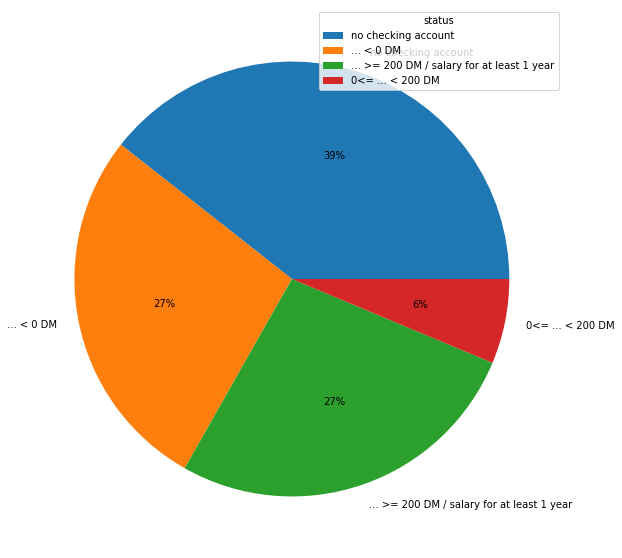

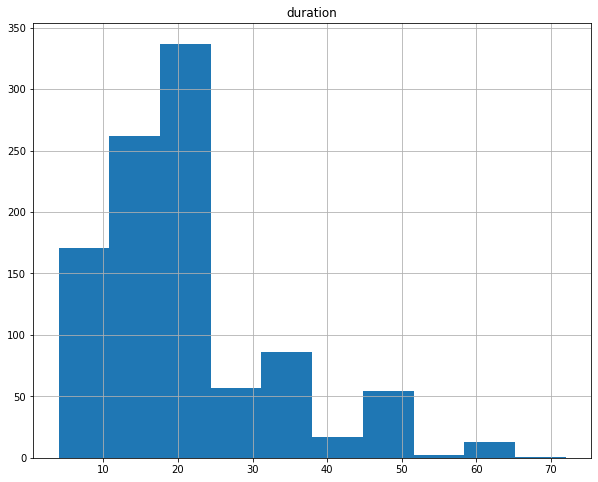

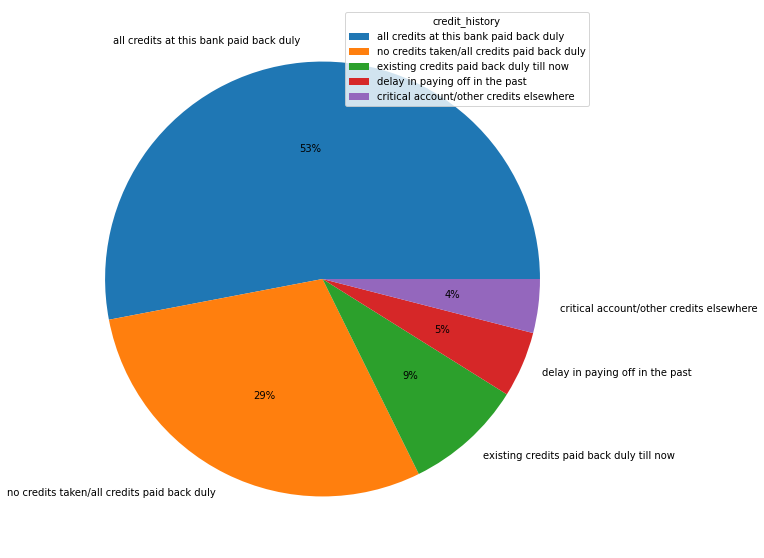

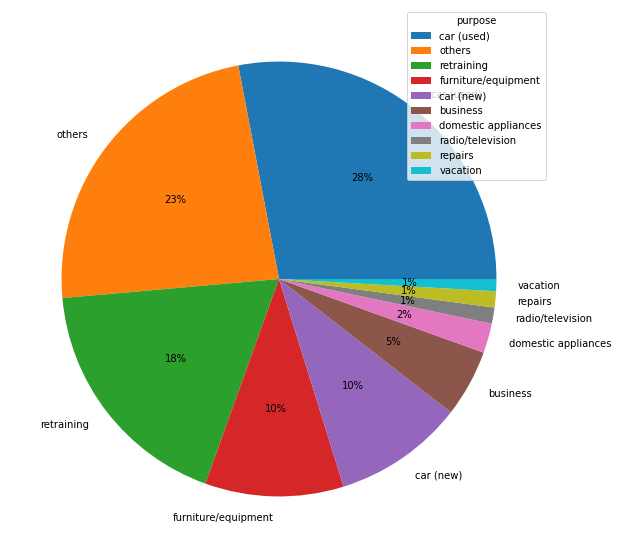

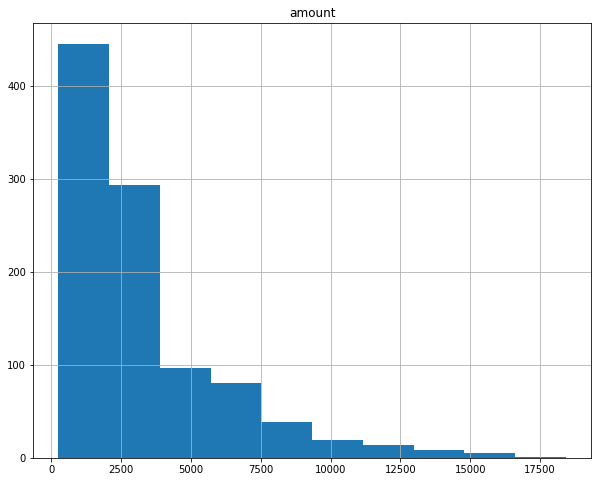

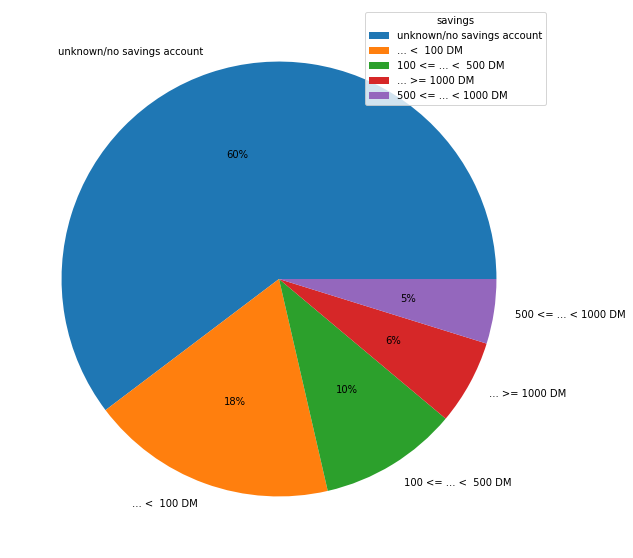

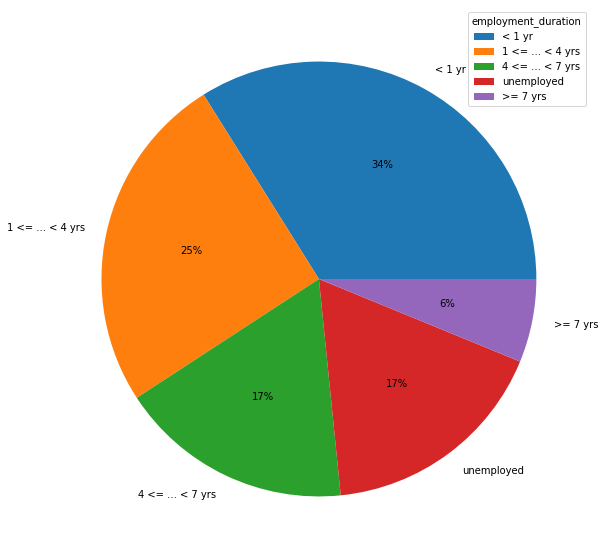

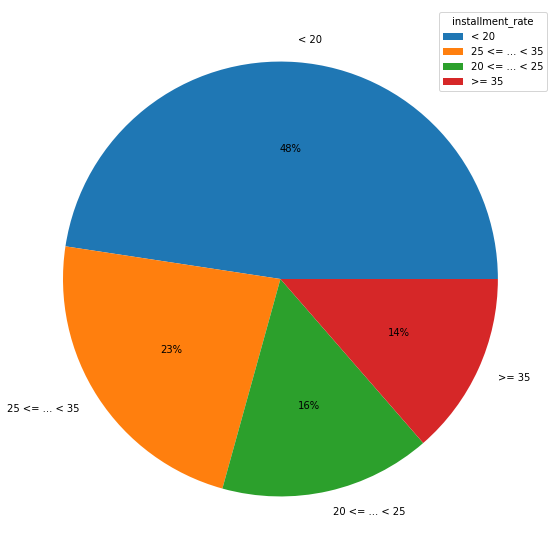

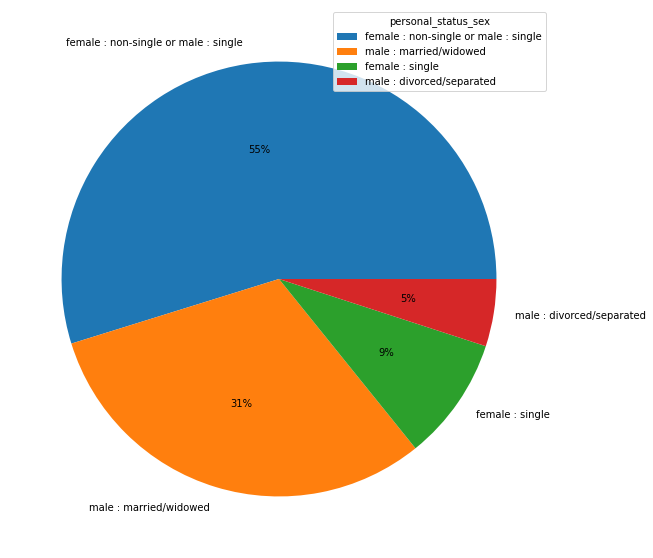

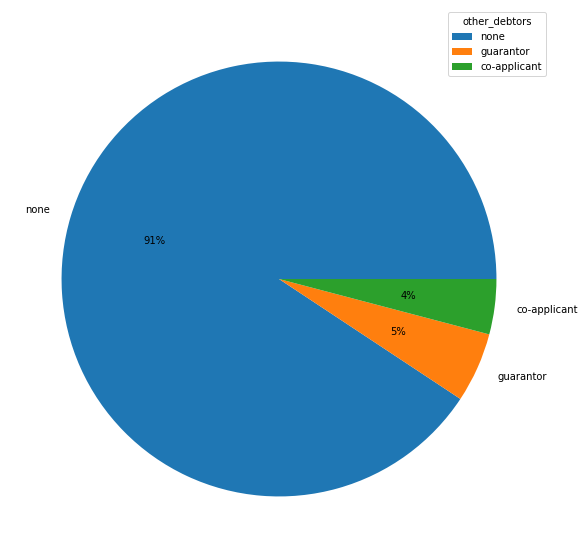

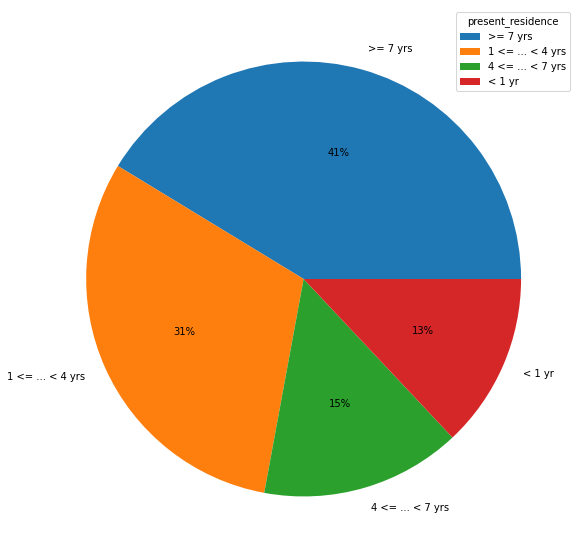

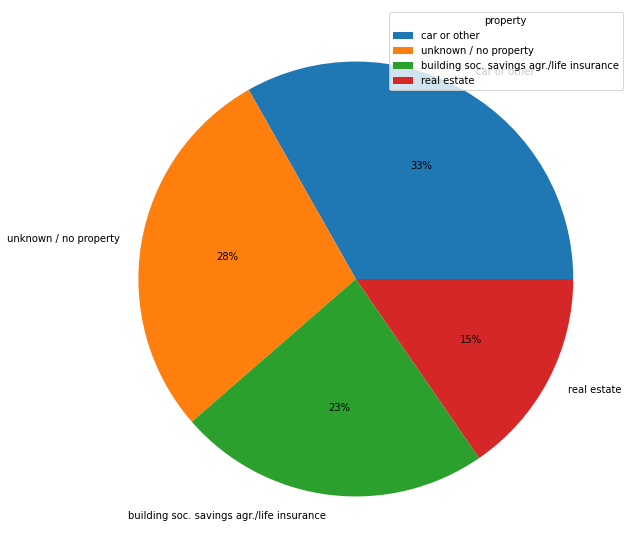

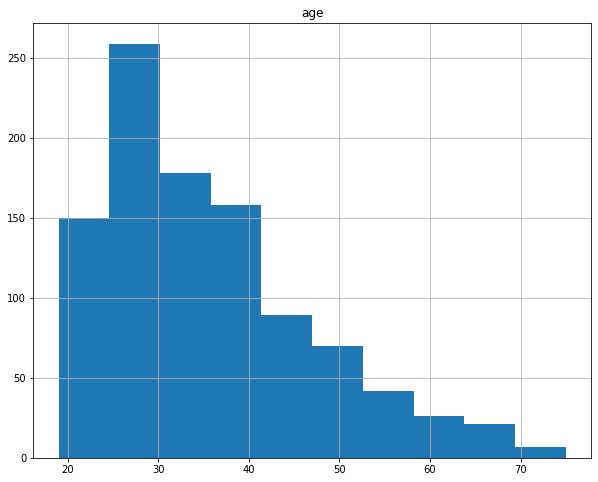

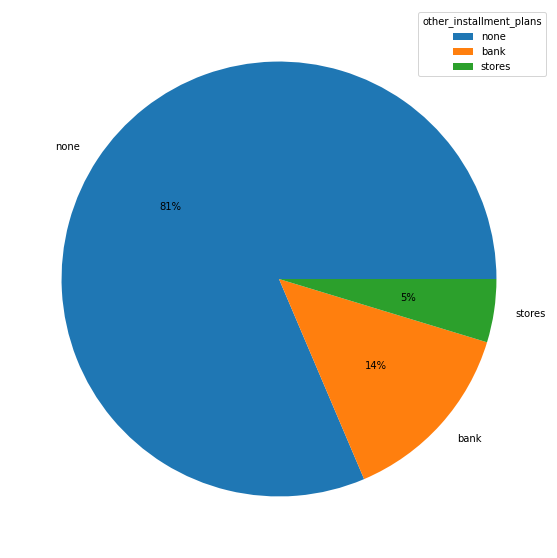

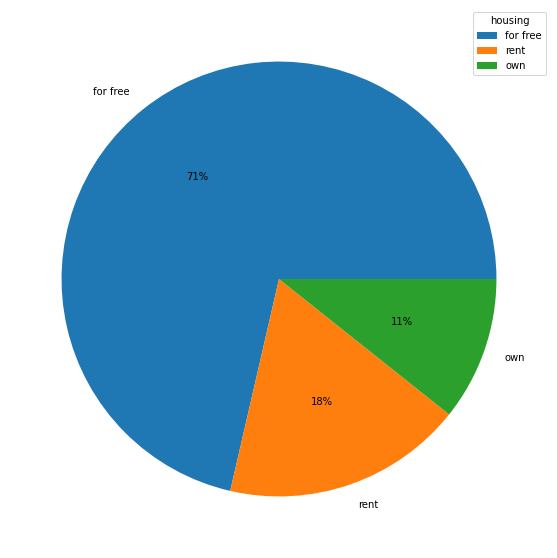

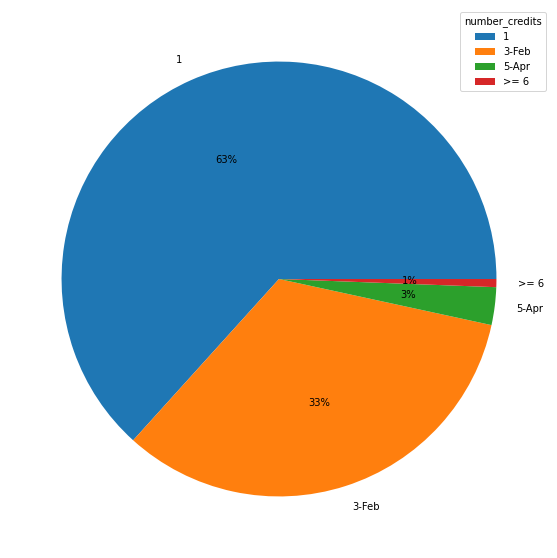

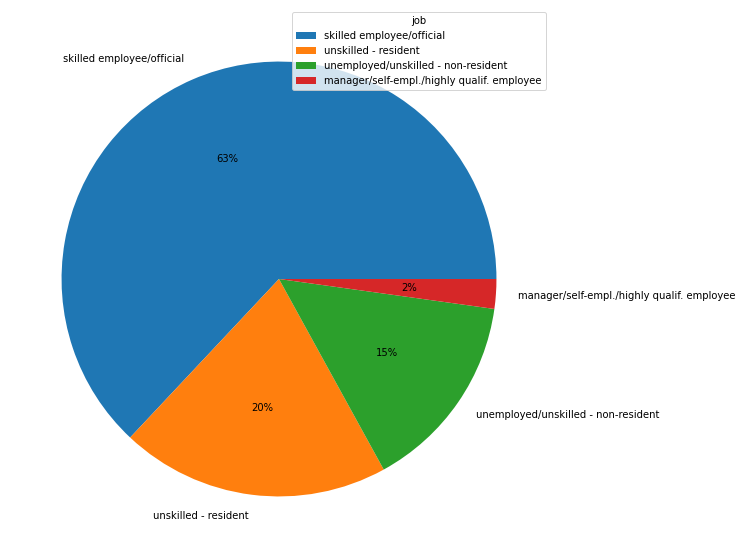

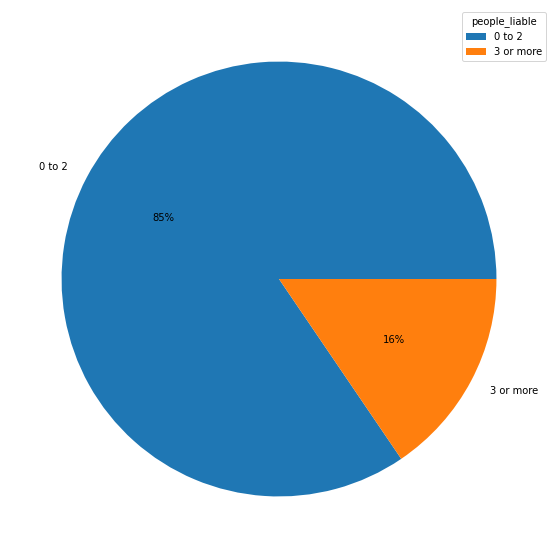

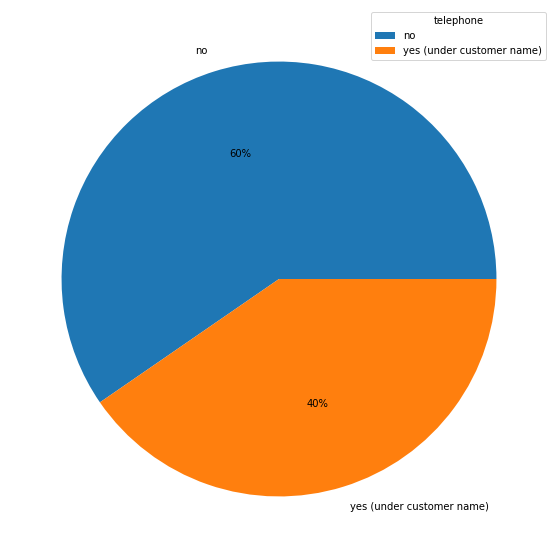

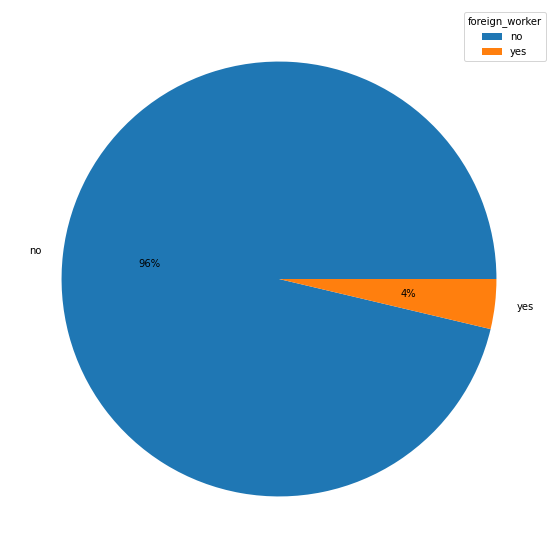

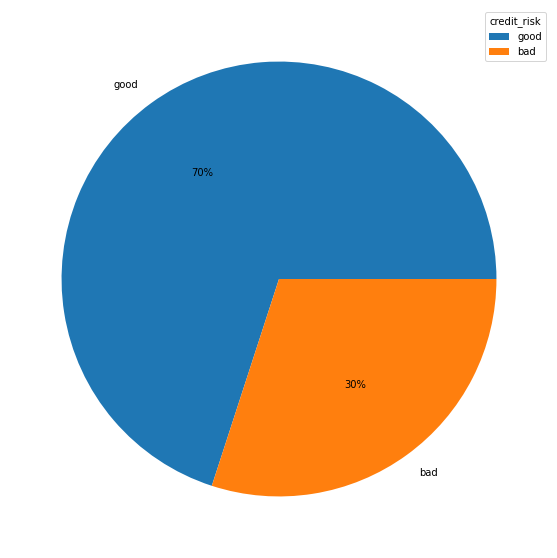

In [51]:
plot_dist(german_bank, 'dataset1')

From looking at our categorical values we can see something is weird with the personal_status_sex feature. This feature is a combination of the individuals sex and their martial status. This can definitely can a cause for concern when regarding bias. According to the data dictionary:

A91 : male   : divorced/separated
A92 : female : divorced/separated/married
A93 : male   : single
A94 : male   : married/widowed
A95 : female : single

We can see that from the values the German Bank is coupling divorced and separated men with value A91. The Bank is classifying those two types of men to be the same when qualifying them for credit. This is an assumption the bank has made and given the values of A92, we can see that they view women the same no matter if they are divorced, separated, or currently married. This assumption raises a red flag because classifying these women as the same can create bias when qualifying for credit. 

We can try to mitigate against what the Bank has done with this particular feature, however, we don't have enough information to decouple this issue completely. With that we can already reject our null hypothesis, clearly the Bank has manipulated the data to group by these categories. We will see later on the implications on this on predicting credit_risk.

### Separating personal_status_sex into gender and marital status

We will try to fix this issue with the personal_status_sex feature by separating into gender and marital status. We can later see how the original dataset performs in comparison to our dataset with bias mitigation changes.

In [52]:
# viewing series
german_bank['personal_status_sex']

0      female : non-single or male : single
1                    male : married/widowed
2      female : non-single or male : single
3                    male : married/widowed
4                    male : married/widowed
                       ...                 
995                  male : married/widowed
996                  male : married/widowed
997                  male : married/widowed
998                  male : married/widowed
999                  male : married/widowed
Name: personal_status_sex, Length: 1000, dtype: object

In [53]:
# importing revised dataset
german_bank_revised = pd.read_csv("data/german_bank_revised.csv")

In [54]:
# viewing revised dataset
german_bank_revised.head()

,Unnamed: 0,checkacct_status,duration_loanterm,credhistory,loan_purpose,credit_amt,saving_acct_bonds,employmt_tenure,install_rate_pctincome,marital_status_gender,...,lbl_saving_acct_bonds,lbl_employmt_tenure,lbl_marital_status_gender,lbl_other_debt,lbl_property_type_assets,lbl_oth_install_plans,lbl_housing_own_rent,lbl_job_type,lbl_telephone_status,lbl_foreign_wkr_status
0,0,< 0 DM,6,critical account/ other credits existing (not...,radio/television,1169,unknown/ no savings account,.. >= 7 years,4,male single,...,4,0,3,2,2,1,1,1,1,1
1,1,0 <= ... < 200 DM,48,existing credits paid back duly till now,radio/television,5951,... < 100 DM,1 <= ... < 4 years,2,female divorced/separated/married,...,1,2,0,2,2,1,1,1,0,1
2,2,no checking account,12,critical account/ other credits existing (not...,education,2096,... < 100 DM,4 <= ... < 7 years,2,male single,...,1,3,3,2,2,1,1,3,0,1
3,3,< 0 DM,42,existing credits paid back duly till now,furniture/equipment,7882,... < 100 DM,4 <= ... < 7 years,2,male single,...,1,3,3,1,0,1,0,1,0,1
4,4,< 0 DM,24,delay in paying off in the past,car (new),4870,... < 100 DM,1 <= ... < 4 years,3,male single,...,1,2,3,2,3,1,0,1,0,1


We want to be able to compare our original dataset and the revised dataset. The original dataset needed changes in order for us to fit a logistic model to it. We used python dictionaries to encode all of the categorical values to numerical values. This will allow our model to properly fit the data and find accurate weighs for our features.

In [55]:
# defining useful functions

# convert unique values into dict with numerical keys
encoders = []

def get_values_dict(df, column):
    value_dict = {}
    values = df[column].unique()
    for index in range(len(values)):
        value_dict[values[index]] = index
    encoders.append(value_dict)
    return value_dict

# convert each item in series based on keys in dict
def convert_cat(item, values_dict):
    return values_dict[item]

# convert series
def convert_column(df, column, values_dict):
    df[column] = df[column].apply(convert_cat, args=(values_dict,))

In [56]:
# convert the all categorical values 
def convert_df(df):
    for col in df.columns:
        if df[col].dtype == "O":
            dict_values = get_values_dict(df, col)
            convert_column(df, col, dict_values)
        else:
            pass


In [57]:
# encoding categorical values
convert_df(german_bank)

In [58]:
# previewing data
german_bank.head()

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
0,0,18,0,0,1049,0,0,0,0,0,...,0,21,0,0,0,0,0,0,0,0
1,0,9,0,1,2799,0,1,1,1,0,...,1,36,0,0,1,0,1,0,0,0
2,1,12,1,2,841,1,2,1,0,0,...,1,23,0,0,0,1,0,0,0,0
3,0,12,0,1,2122,0,1,2,1,0,...,1,39,0,0,1,1,1,0,1,0
4,0,12,0,1,2171,0,1,0,1,0,...,0,38,1,1,1,1,0,0,1,0


In [59]:
german_bank.describe()

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,...,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.246000,20.903000,1.022000,2.437000,3271.24800,0.970000,1.885000,0.95300,0.882000,0.134000,...,1.408000,35.54200,0.233000,0.928000,0.407000,0.688000,0.155000,0.404000,0.037000,0.300000
std,0.927547,12.058814,0.991211,2.112935,2822.75176,1.353119,1.445636,1.08442,0.767245,0.445244,...,1.007249,11.35267,0.522479,0.530186,0.577654,1.071356,0.362086,0.490943,0.188856,0.458487
min,0.000000,4.000000,0.000000,0.000000,250.00000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,19.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,12.000000,0.000000,1.000000,1365.50000,0.000000,1.000000,0.00000,0.000000,0.000000,...,1.000000,27.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,18.000000,1.000000,2.000000,2319.50000,0.000000,1.000000,1.00000,1.000000,0.000000,...,1.000000,33.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,24.000000,1.000000,3.000000,3972.25000,2.000000,4.000000,2.00000,1.000000,0.000000,...,2.000000,42.00000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,3.000000,72.000000,4.000000,9.000000,18424.00000,4.000000,4.000000,3.00000,3.000000,2.000000,...,3.000000,75.00000,2.000000,2.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


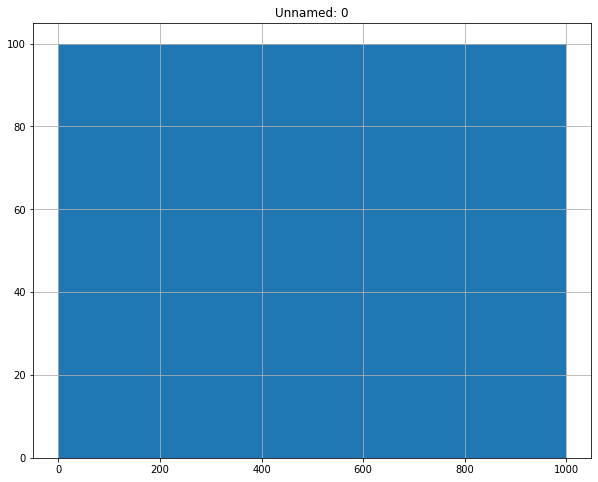

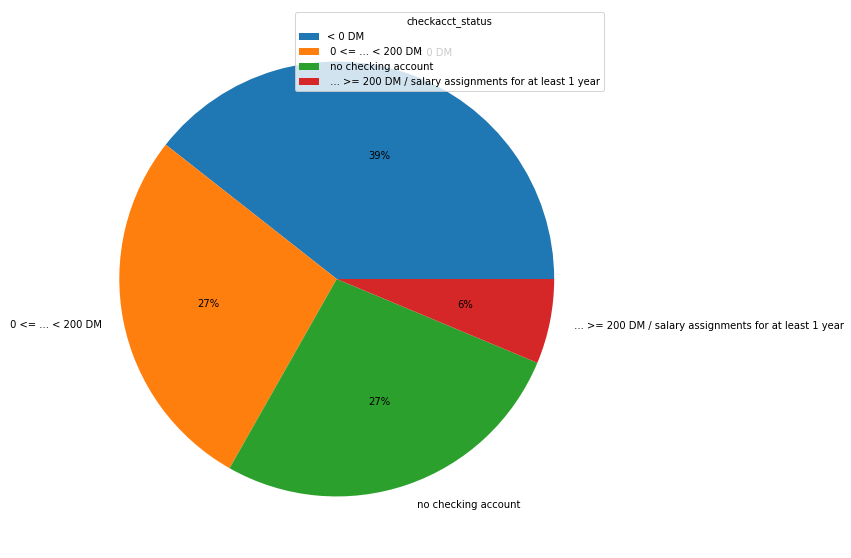

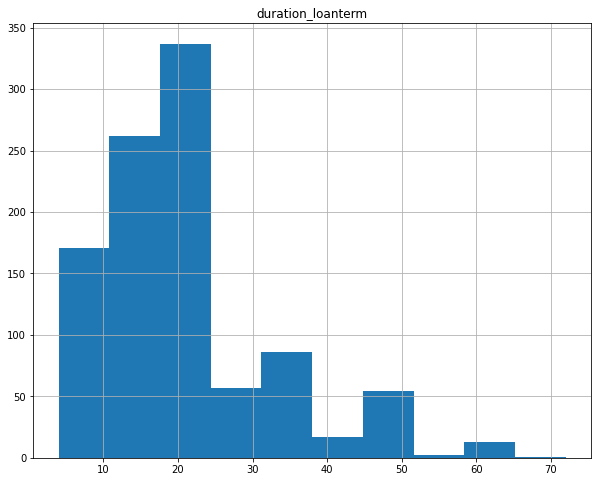

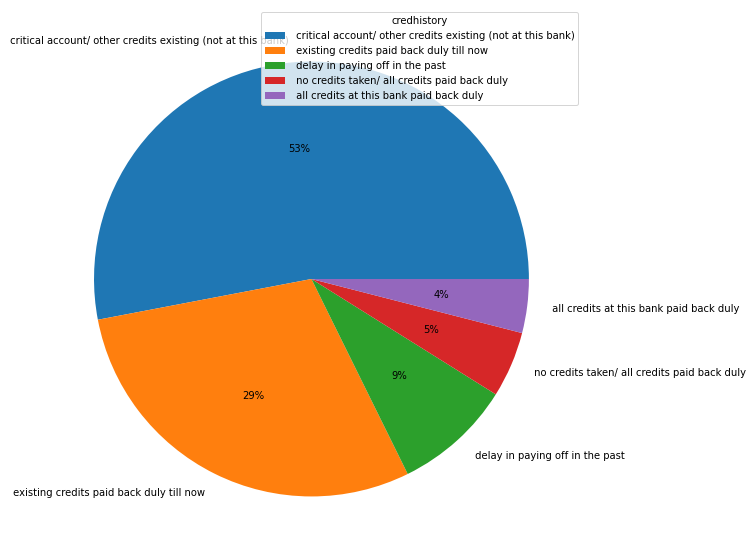

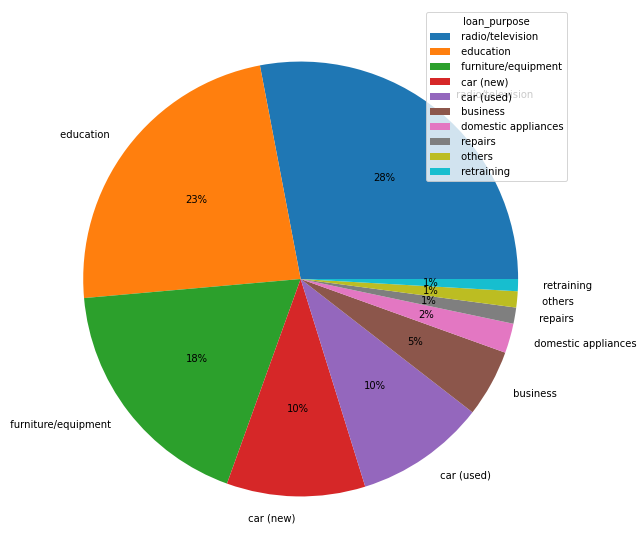

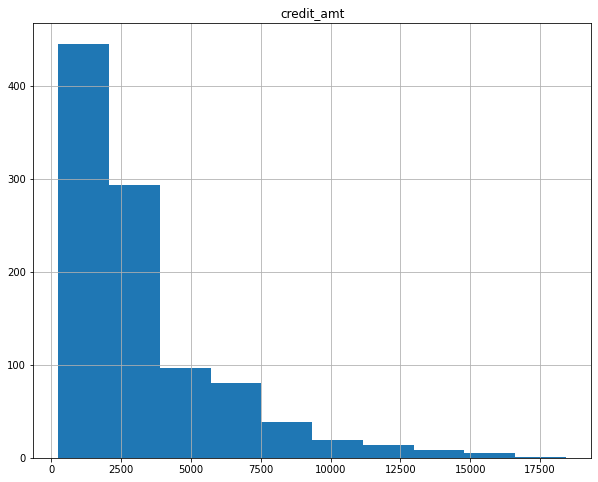

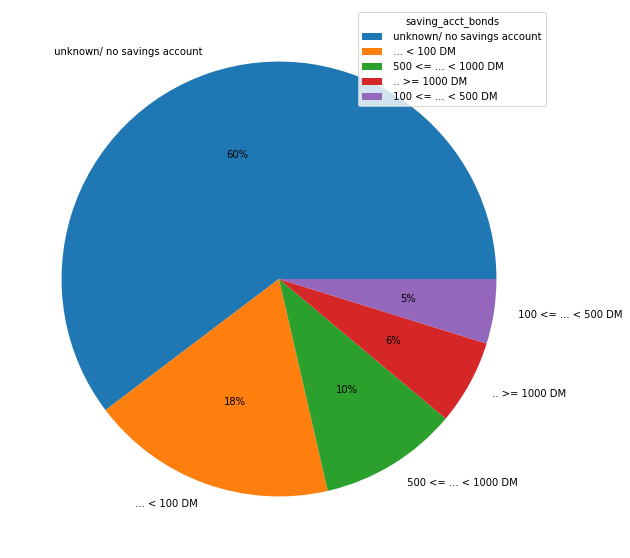

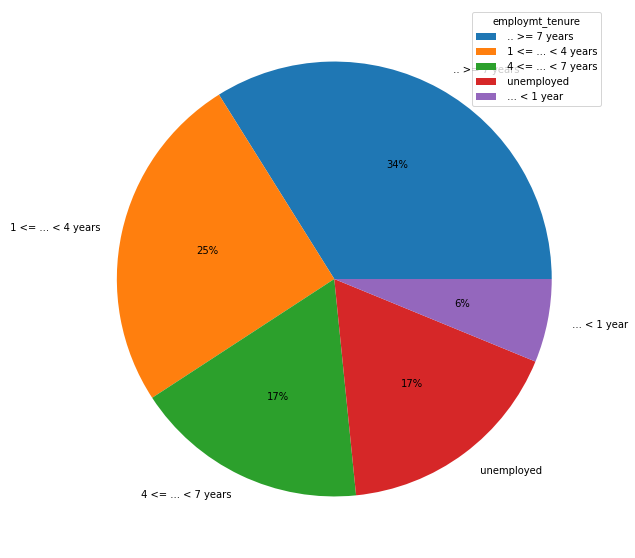

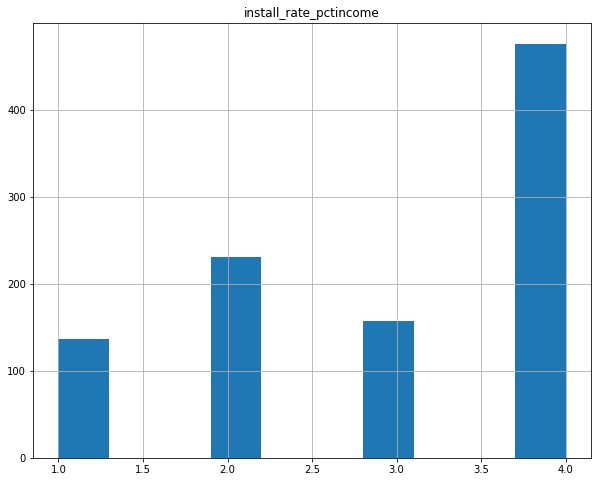

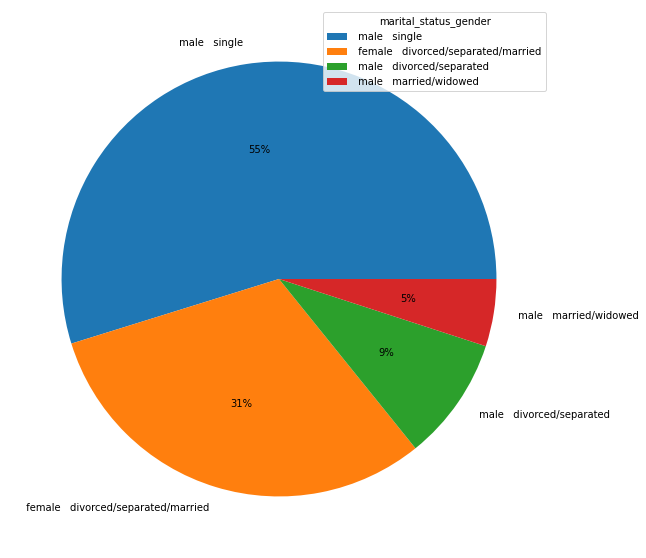

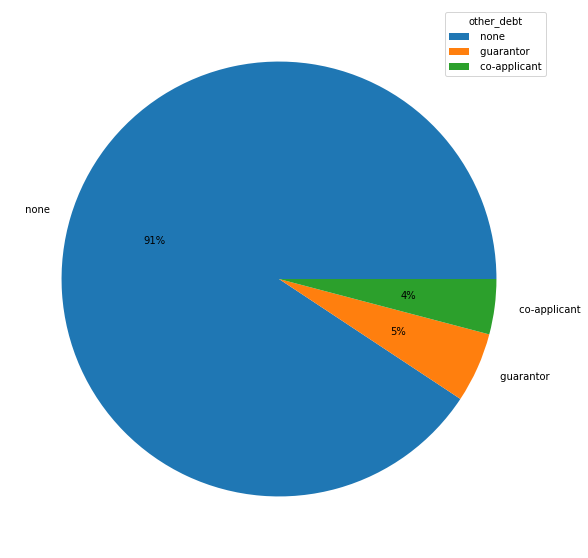

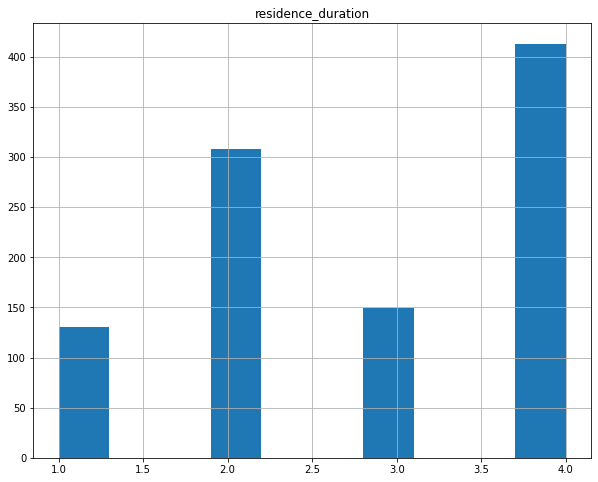

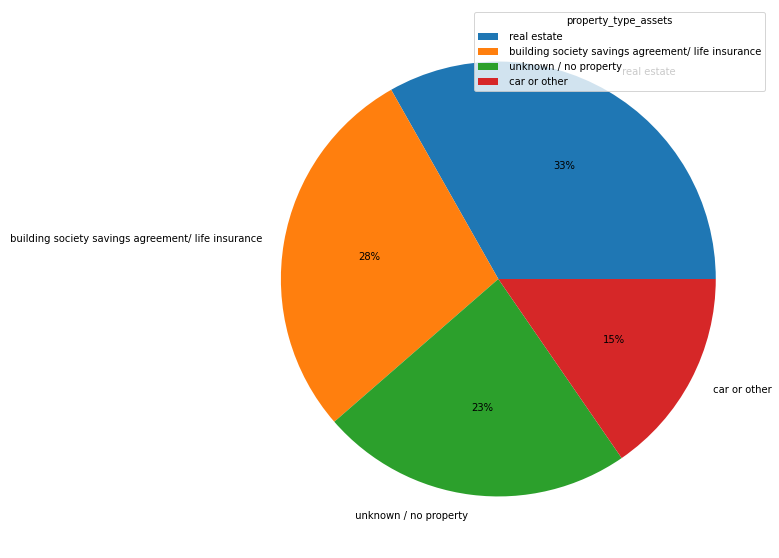

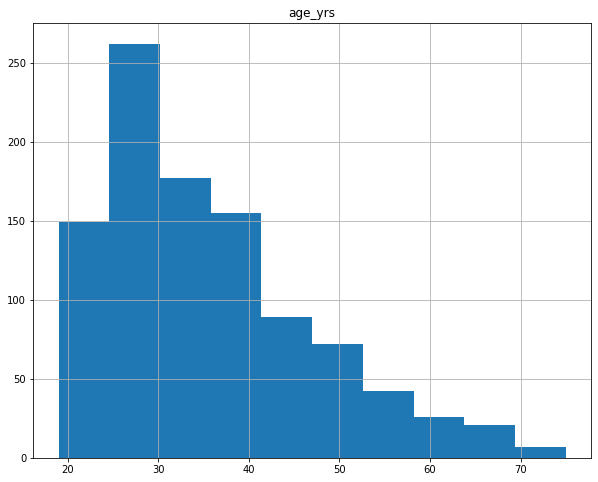

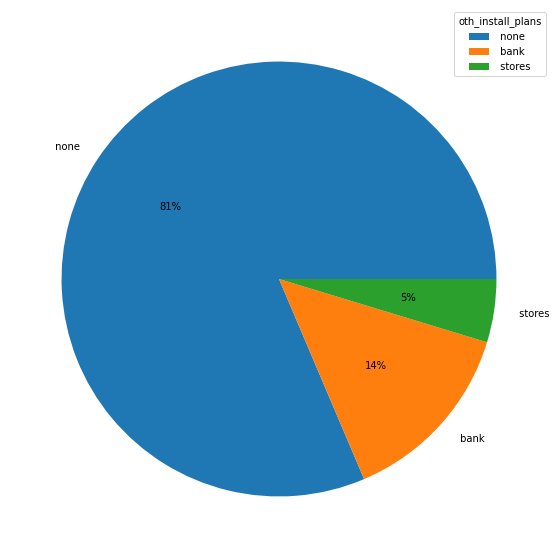

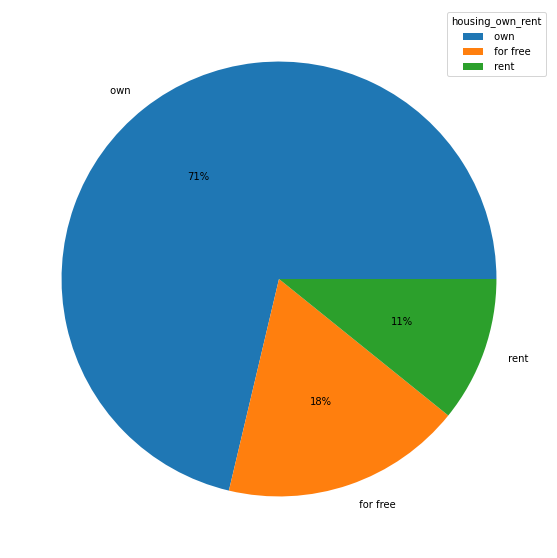

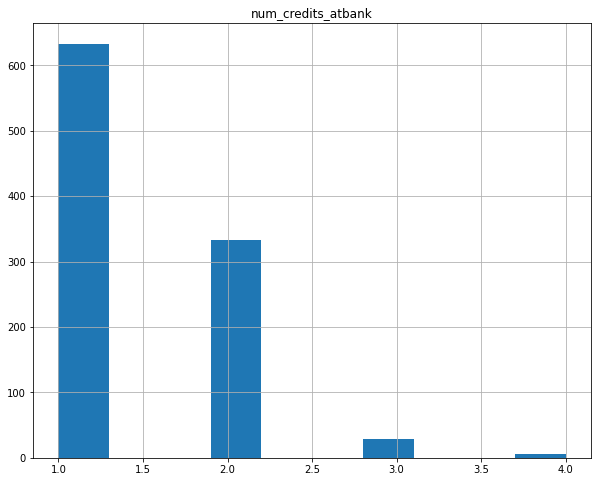

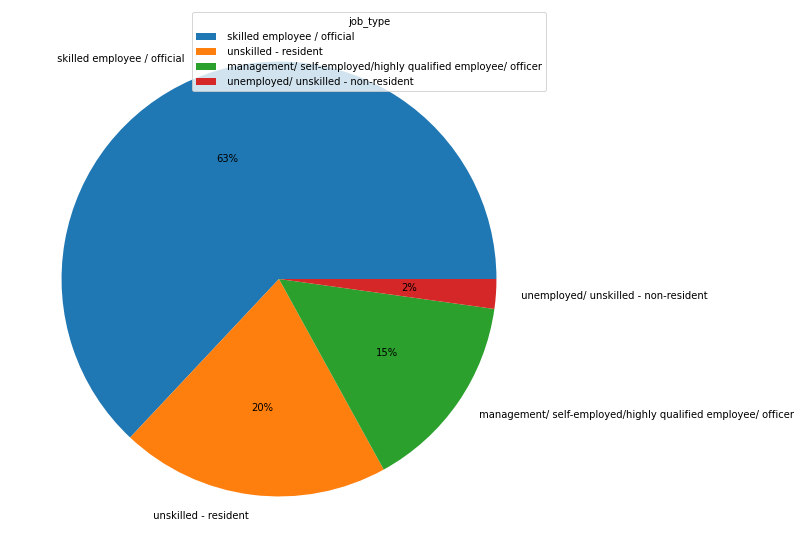

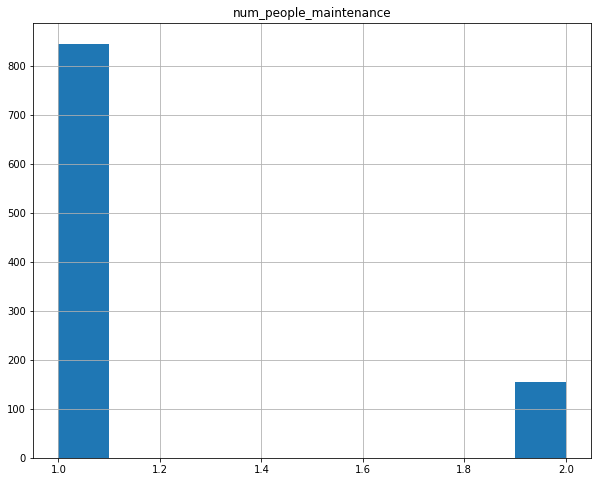

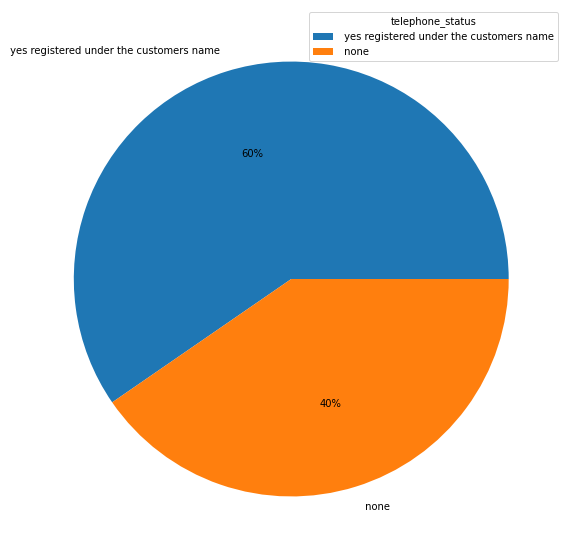

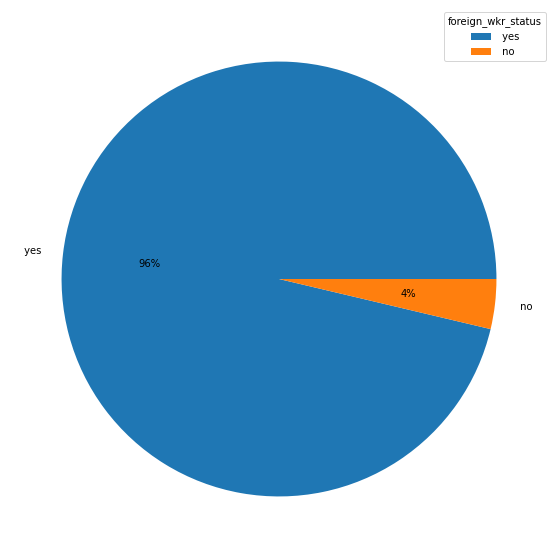

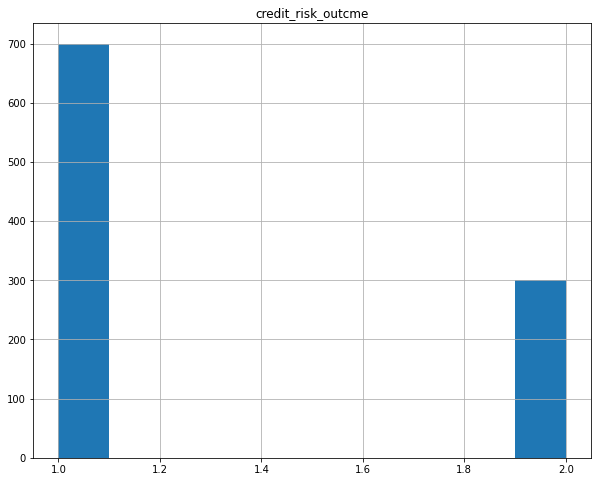

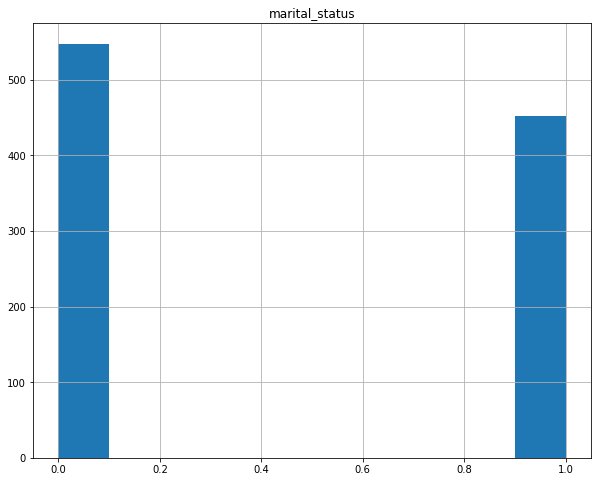

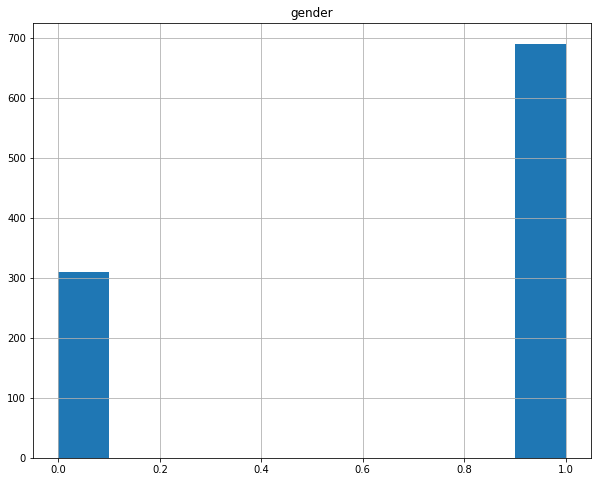

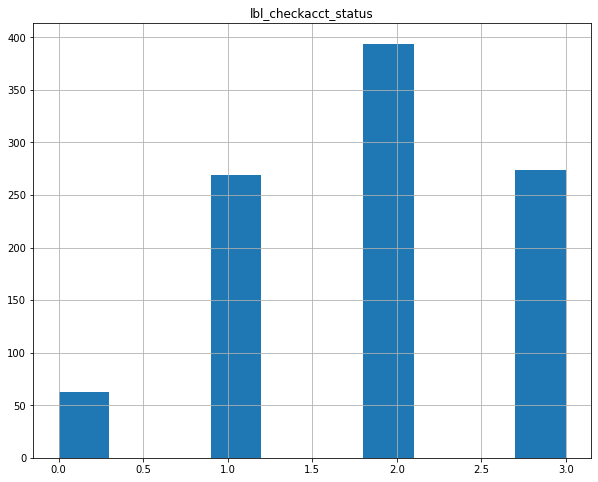

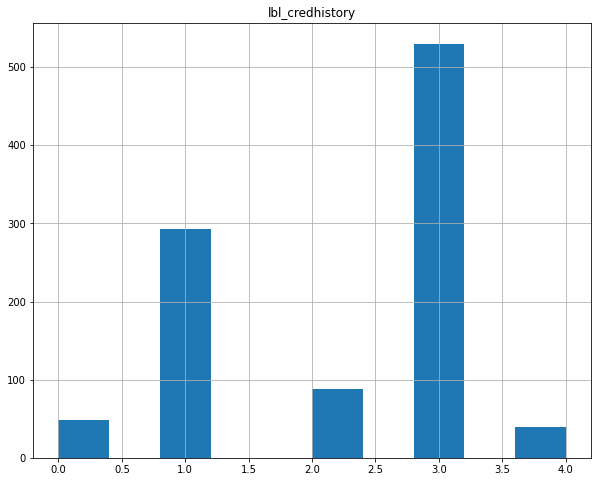

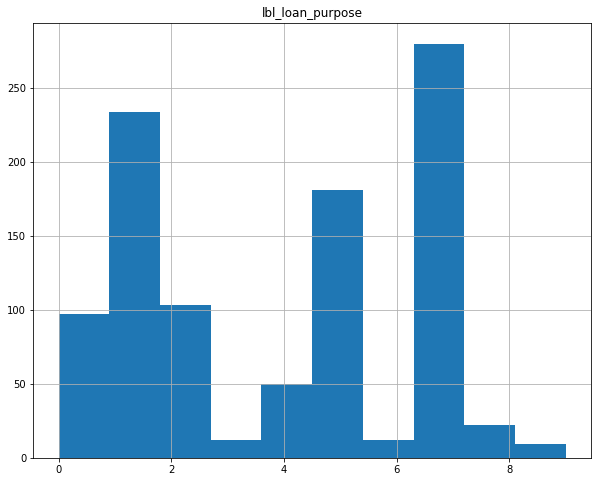

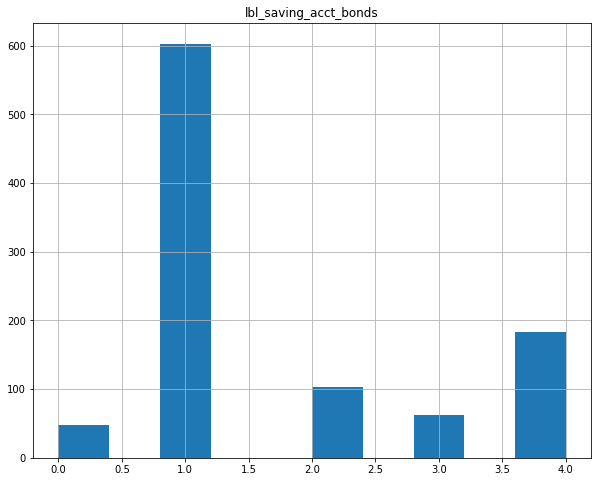

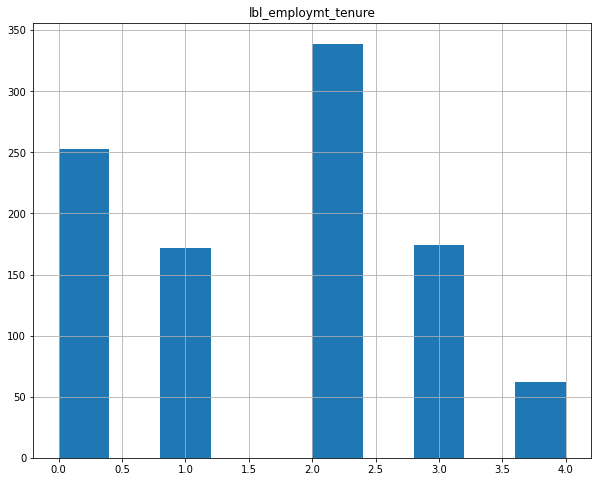

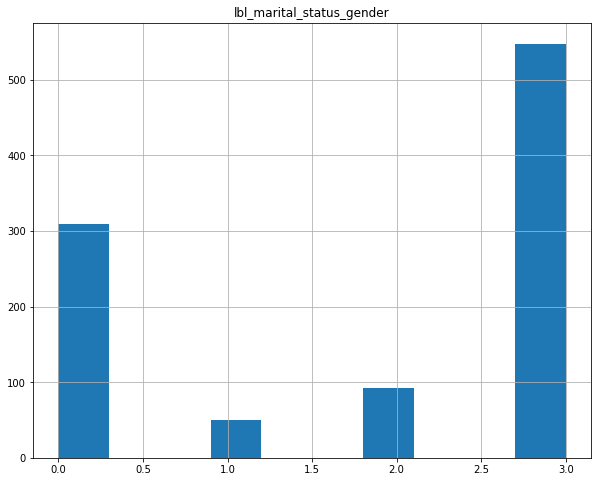

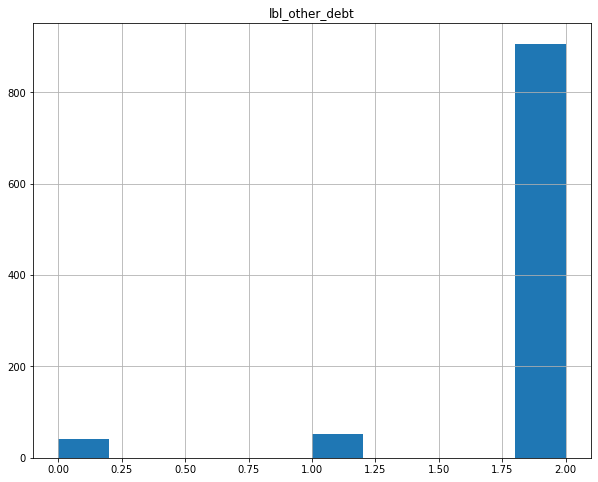

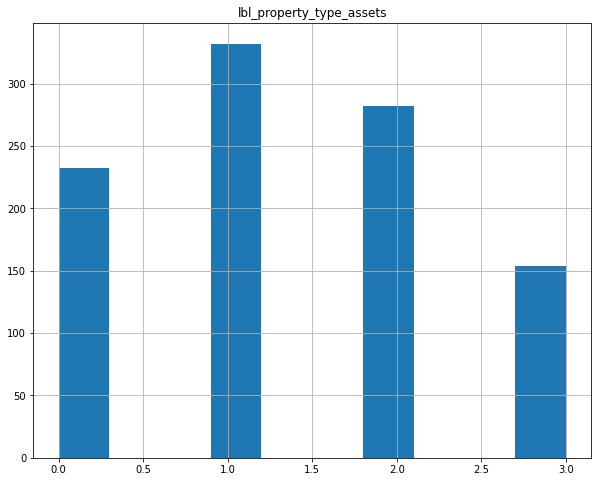

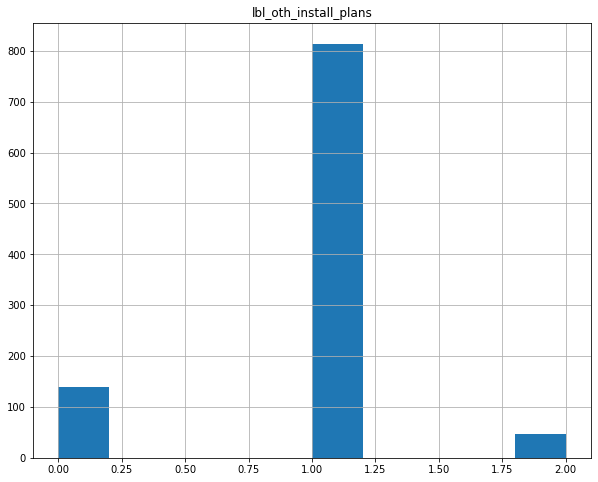

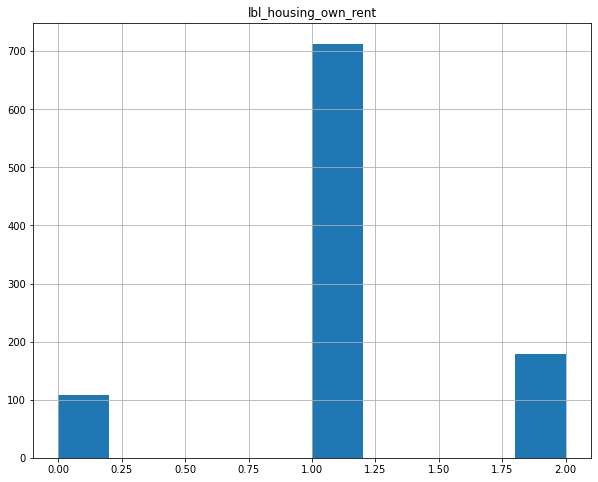

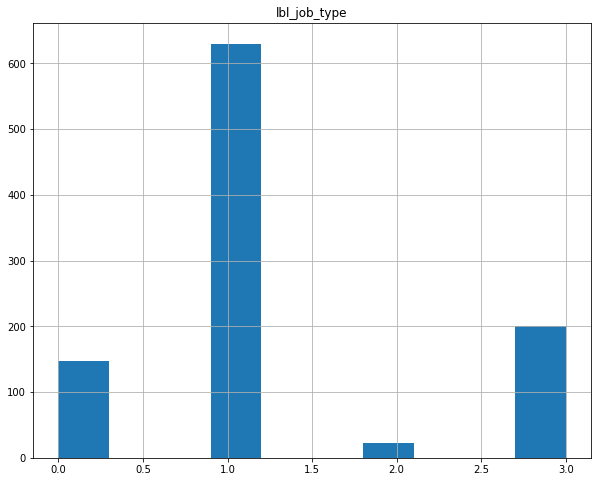

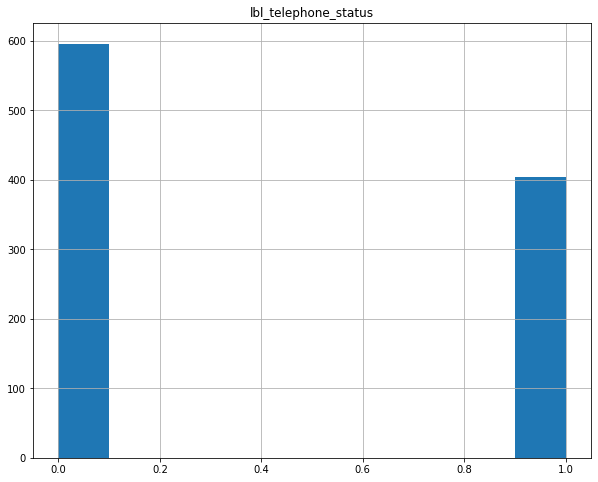

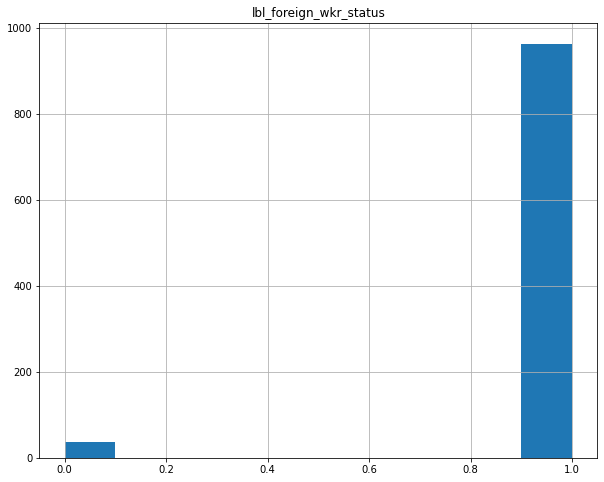

In [60]:
plot_dist(german_bank_revised, 'dataset2')

## Modeling
We create two logistic regression models and we evaluate how they preform.

**Evaluating model 1**

In [61]:
# features
x = german_bank[['status','duration',
                 'credit_history','purpose',
                 'savings','employment_duration',
                 'installment_rate','personal_status_sex','other_debtors',
                'property','other_installment_plans','housing','number_credits']]
# target variable
y = german_bank['credit_risk']

# creating model and fitting data
model = LogisticRegression(solver='liblinear', random_state=0)

# using 10% for testing and 90% for training
# train_test_split automatically splits our data into a distributed sample
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

model.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [62]:
# intercept 
model.intercept_

array([-0.44280023])

In [63]:
# coefficients
model.coef_

array([[-0.66450738,  0.03234895,  0.37310719, -0.03922051, -0.28247456,
        -0.14242697, -0.17309412, -0.09662876, -0.20090421,  0.14401903,
         0.11805857, -0.18844549,  0.00364749]])

In [66]:
# our model class is our target variable 
model.classes_

array([0, 1])

In [67]:
# coefficient for personal_status_sex
model.coef_.tolist()[0][7]

-0.09662875707786266

In [68]:
# grabbing the label encoder for the column
encoders[6]

{'female : non-single or male : single': 0,
 'male : married/widowed': 1,
 'female : single': 2,
 'male : divorced/separated': 3}

The label encoder was used to  transform non-numerical labels to numerical labels. However, given how the labels are coupled in this case we should have used a one-hot label encoder to change the way the logistic regression weighs this coefficient. 
The interpretation of the -0.071 coefficient means that 

We can check its performance with .predict_proba(), which returns the matrix of probabilities that the predicted output is equal to zero or one

In [69]:
model.predict_proba(X_train)

array([[0.78873297, 0.21126703],
       [0.62660675, 0.37339325],
       [0.43898226, 0.56101774],
       ...,
       [0.65597489, 0.34402511],
       [0.77367191, 0.22632809],
       [0.75522625, 0.24477375]])

We can get the actual predictions, based on the probability matrix and the values of 𝑝(𝑥), with .predict()

In [70]:
model.predict(X_train)

array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,

In [71]:
model.score(X_train, y_train)

0.7522222222222222

.score() takes the input and output as arguments and returns the ratio of the number of correct predictions to the number of observations.

You can get more information on the accuracy of the model with a confusion matrix. In the case of binary classification, the confusion matrix shows the numbers of the following:

True negatives in the upper-left position
False negatives in the lower-left position
False positives in the upper-right position
True positives in the lower-right position

In [72]:
confusion_matrix(y_train, model.predict(X_train))

array([[569,  64],
       [159, 108]])

The obtained matrix shows the following:

Three true negative predictions: The first three observations are zeros predicted correctly.
No false negative predictions: These are the ones wrongly predicted as zeros.
One false positive prediction: The fourth observation is a zero that was wrongly predicted as one.
Six true positive predictions: The last six observations are ones predicted correctly.


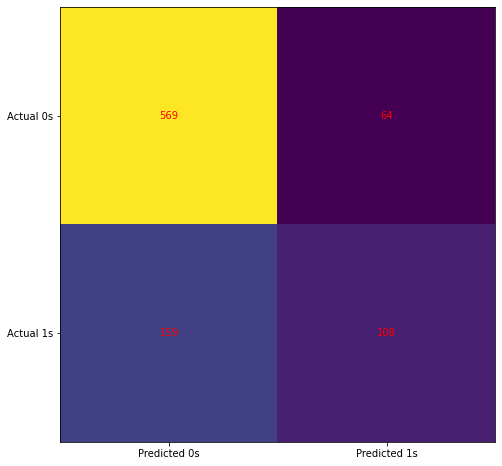

In [73]:
cm = confusion_matrix(y_train, model.predict(X_train))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [74]:
print(classification_report(y_train, model.predict(X_train)))

              precision    recall  f1-score   support

           0       0.78      0.90      0.84       633
           1       0.63      0.40      0.49       267

    accuracy                           0.75       900
   macro avg       0.70      0.65      0.66       900
weighted avg       0.74      0.75      0.73       900



**Evaluating model 2**

In model 2 we are using the separated matrial and sex features to predict credit risk instead of the coupled personal_status_sex feature. 

In [75]:
# viewing columns
german_bank_revised.columns

Index(['Unnamed: 0', 'checkacct_status', 'duration_loanterm', 'credhistory',
       'loan_purpose', 'credit_amt', 'saving_acct_bonds', 'employmt_tenure',
       'install_rate_pctincome', 'marital_status_gender', 'other_debt',
       'residence_duration', 'property_type_assets', 'age_yrs',
       'oth_install_plans', 'housing_own_rent', 'num_credits_atbank',
       'job_type', 'num_people_maintenance', 'telephone_status',
       'foreign_wkr_status', 'credit_risk_outcme', 'marital_status', 'gender',
       'lbl_checkacct_status', 'lbl_credhistory', 'lbl_loan_purpose',
       'lbl_saving_acct_bonds', 'lbl_employmt_tenure',
       'lbl_marital_status_gender', 'lbl_other_debt',
       'lbl_property_type_assets', 'lbl_oth_install_plans',
       'lbl_housing_own_rent', 'lbl_job_type', 'lbl_telephone_status',
       'lbl_foreign_wkr_status'],
      dtype='object')

In [89]:
german_bank_revised.marital_status.unique()

array([0, 1])

In [76]:
# grabbing the same features and including the separated marital and gender 
x = german_bank_revised[['lbl_checkacct_status','duration_loanterm',
                 'lbl_credhistory','lbl_loan_purpose',
                 'lbl_saving_acct_bonds','lbl_employmt_tenure',
                 'lbl_oth_install_plans','lbl_other_debt',
                'lbl_property_type_assets','lbl_housing_own_rent','num_credits_atbank', 'marital_status','gender']]
# target variable
y = german_bank_revised['credit_risk_outcme']

# creating model and fitting data
model = LogisticRegression(solver='liblinear', random_state=0)

# using 10% for testing and 90% for training
# train_test_split automatically splits our data into a distributed sample
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

model.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [77]:
# intercept 
model.intercept_

array([-1.13319917])

In [78]:
# coefficients
model.coef_

array([[ 0.20949238,  0.03955574,  0.1442243 , -0.07166137, -0.27643969,
        -0.03387984, -0.29061632, -0.09376148,  0.07668025,  0.08027129,
        -0.15209262,  0.23808244, -0.22277983]])

In [79]:
# our model class is our target variable
model.classes_

array([1, 2])

In [80]:
model.predict_proba(X_train)

array([[0.47591655, 0.52408345],
       [0.56799684, 0.43200316],
       [0.80929078, 0.19070922],
       ...,
       [0.73122906, 0.26877094],
       [0.78963215, 0.21036785],
       [0.83186078, 0.16813922]])

In [81]:
model.predict(X_train)

array([2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1,

In [82]:
model.score(X_train, y_train)

0.7188888888888889

This model 0.73 score, which is lower than the 0.7622 of the first model. The german bank that was using this dataset, if they were running a similar model they most likely coupled the data because it performed better within their model. However, although the model may perform better using the coupled features rather than using the separated features it is not an excuse to introduce bias into the model. 

In [83]:
confusion_matrix(y_train, model.predict(X_train))

array([[590,  35],
       [218,  57]])

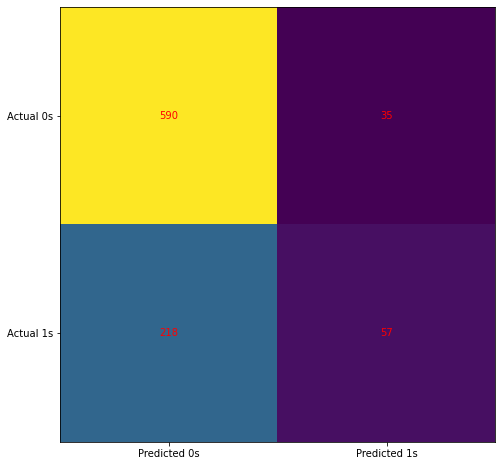

In [84]:
cm = confusion_matrix(y_train, model.predict(X_train))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [85]:
print(classification_report(y_train, model.predict(X_train)))

              precision    recall  f1-score   support

           1       0.73      0.94      0.82       625
           2       0.62      0.21      0.31       275

    accuracy                           0.72       900
   macro avg       0.67      0.58      0.57       900
weighted avg       0.70      0.72      0.67       900

